## Creates binarized Seurat objects, integrates conditions and annotates genes by nearby peaks

In [1]:
# Input info
#cellr_in = "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/DUPI_april08_2021_Croker/MTblacklist_mtasnucl/" 
cellr_in = "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/CHIP_dec172021_b2/MTblacklist_A2/"

outdir = "/mnt/md0/isshamie/Projects/Mito_Trace/output/pipeline/v04/CHIP_b2/InputOnly/MTBlacklist_A2/data/annotation/gff_A2_black/external_granja/"
sample_names = "Input"
samples = "Input"

# Parameters
nTop = 25000
cores = 24
gff_id = "hg38_1_2"

annotations_indir = "/mnt/md0/isshamie/Projects/Mito_Trace/data/processed/annotation_granges/"

# External
external_dat_dir <- "/data/isshamie/mito_lineage/output/annotation/data/granja_cd3"
external_frag_file <- "/data/isshamie/mito_lineage/output/annotation/data/granja_cd34/granja_cd34.fragments.sort.tsv.gz"
external_prefix <- "GSE129785_scATAC-Hematopoiesis-CD34"
ext_name <- "granja_cd34"


# Parameters
nTop = 25000
lsi_start_comp = 2
to.filt.cells = "TRUE"


to.qc = FALSE
## QC parameters
# min_peak_region_fragments=1000
# max_peak_region_fragments=10000
# min_pct_reads_in_peaks=20
# max_blacklist_ratio=0.05
# max_nucleosome_signal=15
# min_TSS_enrichment=0.2

min_peak_region_fragments=10
max_peak_region_fragments=15000
min_pct_reads_in_peaks=15
max_blacklist_ratio=0.05
max_nucleosome_signal=4
min_TSS_enrichment=0.2


In [ ]:
if ((to.filt.cells == "T") | (to.filt.cells == "TRUE")){
    to.filt.cells = TRUE
}else{to.filt.cells = FALSE}


In [2]:
library(repr)
options(repr.plot.width=12, repr.plot.height=12)

In [3]:
samples <- unlist(strsplit(samples, ",")[[1]])
sample_names <- unlist(strsplit(sample_names, ","))

samples

[1] "rxn2" "rxn4"

In [ ]:
# Change to the sorted fragment file!
ext_frag_file <- gsub('.fragments.tsv', '.fragments.sort.tsv.gz', external_frag_file)

external_dat_dir <- dirname(external_frag_file)
external_frag_file

In [4]:
annotations <- readRDS(file.path(annotations_indir, paste0(gff_id, ".annotationGranges.rds")))

In [5]:
annotations

Loading required package: GenomicRanges

Loading required package: stats4

Loading required package: BiocGenerics


Attaching package: ‘BiocGenerics’


The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs


The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which.max, which.min


Loading required package: S4Vectors


Attaching package: ‘S4Vectors’


The following objects are masked from ‘package:base’:

    expand.grid, I, unname


Loading required package: IRanges

Loading required package: GenomeInfoDb



GRanges object with 1684537 ranges and 21 metadata columns:
            seqnames      ranges strand |   source       type     score
               <Rle>   <IRanges>  <Rle> | <factor>   <factor> <numeric>
        [1]     chr1 11869-14409      + |   HAVANA gene              NA
        [2]     chr1 11869-14409      + |   HAVANA transcript        NA
        [3]     chr1 11869-12227      + |   HAVANA exon              NA
        [4]     chr1 12613-12721      + |   HAVANA exon              NA
        [5]     chr1 13221-14409      + |   HAVANA exon              NA
        ...      ...         ...    ... .      ...        ...       ...
  [1684533]     chrM 15888-15953      + |  ENSEMBL transcript        NA
  [1684534]     chrM 15888-15953      + |  ENSEMBL exon              NA
  [1684535]     chrM 15956-16023      - |  ENSEMBL gene              NA
  [1684536]     chrM 15956-16023      - |  ENSEMBL transcript        NA
  [1684537]     chrM 15956-16023      - |  ENSEMBL exon              NA
    

In [6]:
library(GenomicRanges)
library(Seurat)
library(Signac)
library(GenomeInfoDb)
#library(EnsDb.Hsapiens.v75)
library(ggplot2)
library(patchwork)
set.seed(1234)
library(data.table)
library(magrittr)
library(cowplot)
library(metap)
library(dplyr)
library(future)

plan("multiprocess", workers = cores)
options(future.globals.maxSize = 8000 * 1024^2)
#options(future.globals.maxSize = 50000 * 1024^2) # for 50 Gb RAM
#plan("multiprocess", workers = workers)

Attaching SeuratObject


Attaching package: ‘data.table’


The following object is masked from ‘package:GenomicRanges’:

    shift


The following object is masked from ‘package:IRanges’:

    shift


The following objects are masked from ‘package:S4Vectors’:

    first, second



Attaching package: ‘cowplot’


The following object is masked from ‘package:patchwork’:

    align_plots



Attaching package: ‘dplyr’


The following objects are masked from ‘package:data.table’:

    between, first, last


The following objects are masked from ‘package:GenomicRanges’:

    intersect, setdiff, union


The following object is masked from ‘package:GenomeInfoDb’:

    intersect


The following objects are masked from ‘package:IRanges’:

    collapse, desc, intersect, setdiff, slice, union


The following objects are masked from ‘package:S4Vectors’:

    first, intersect, rename, setdiff, setequal, union


The following objects are masked from ‘package:BiocGenerics’:

    combine, intersect, set

In [ ]:


# # Create a unified set of peaks to quantify in each dataset
# #combined.peaks <- reduce(x = c(gr.500, gr.1k, gr.5k, gr.10k))
# combined.peaks <- reduce(x = c(gr.ext, gr.curr))

# # Filter out bad peaks based on length
# peakwidths <- width(combined.peaks)
# combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
# combined.peaks

## External data processing

In [ ]:
barcode_path <- file.path(external_dat_dir, paste0(external_prefix, ".cell_barcodes.txt"))

metadata <- read.csv(
  file = file.path(external_dat_dir, paste0(external_prefix, ".cell_barcodes.txt")),
  header = TRUE,
  sep='\t',
)
#CD34boo <- colData$Group %in% c("CD34_Progenitors_Rep1","CD34_Progenitors_Rep2")
c1boo <-  metadata$Group %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP")
metadata <- metadata[c1boo,]

rownames(metadata) <- metadata$Group_Barcode
metadata$proj <- "granja_cd34"
ext_cell_names <- rownames(metadata)
metadata <- metadata[,c("Group", "proj")]
ext_cell_names



## Merge all peaks

In [7]:
read.peaks <- function(exp, cellr_in){
    print('here')
    print(file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"))
    peaks <- read.table(
      file = file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "peaks.bed"),
      col.names = c("chr", "start", "end")
    )
    # convert to genomic ranges
    gr <- makeGRangesFromDataFrame(peaks)
    return(gr)
}


gr.full <- c(sapply(samples, read.peaks, cellr_in=cellr_in, USE.NAMES=F))

gr.full.c <- gr.full[[1]]
if (length(gr.full)>1){
    for (i in 2:length(gr.full)){
      gr.full.c <- c(gr.full.c, gr.full[[i]])
    }
}
combined.peaks <- reduce(x = c(gr.full.c))

# read in peak sets
peaks.ext <- read.table(
  file = file.path(external_dat_dir, paste0(external_prefix, ".peaks.bed")),
  col.names = c("chr", "start", "end")
)

# convert to genomic ranges
gr.ext <- makeGRangesFromDataFrame(peaks.ext)

combined.peaks <- reduce(x = c(gr.ext, combined.peaks))


# Filter out bad peaks based on length
peakwidths <- width(combined.peaks)
combined.peaks <- combined.peaks[peakwidths  < 10000 & peakwidths > 20]
head(combined.peaks)

[1] "here"
[1] "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/DUPI_april08_2021_Croker/MTblacklist_mtasnucl//rxn2/outs/filtered_peak_bc_matrix/peaks.bed"
[1] "here"
[1] "/home/isaac/lewis/mito_lineage/output/mtscATAC/data/DUPI_april08_2021_Croker/MTblacklist_mtasnucl//rxn4/outs/filtered_peak_bc_matrix/peaks.bed"


GRanges object with 6 ranges and 0 metadata columns:
      seqnames        ranges strand
         <Rle>     <IRanges>  <Rle>
  [1]     chr1   10169-10267      *
  [2]     chr1 191337-191519      *
  [3]     chr1 268046-268142      *
  [4]     chr1 778355-779233      *
  [5]     chr1 827080-827940      *
  [6]     chr1 844530-844785      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

In [8]:
length(combined.peaks)

[1] 44411

## Are any peaks in the chrM

In [9]:
length(combined.peaks[seqnames(combined.peaks) != "chrM"])


[1] 44411

In [10]:
combined.peaks[seqnames(combined.peaks) == "chrM"]

combined.peaks[seqnames(combined.peaks) == "chr1"]


GRanges object with 0 ranges and 0 metadata columns:
   seqnames    ranges strand
      <Rle> <IRanges>  <Rle>
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

GRanges object with 4387 ranges and 0 metadata columns:
         seqnames              ranges strand
            <Rle>           <IRanges>  <Rle>
     [1]     chr1         10169-10267      *
     [2]     chr1       191337-191519      *
     [3]     chr1       268046-268142      *
     [4]     chr1       778355-779233      *
     [5]     chr1       827080-827940      *
     ...      ...                 ...    ...
  [4383]     chr1 248858094-248859625      *
  [4384]     chr1 248862858-248863683      *
  [4385]     chr1 248872949-248874682      *
  [4386]     chr1 248905881-248907165      *
  [4387]     chr1 248924667-248925484      *
  -------
  seqinfo: 25 sequences from an unspecified genome; no seqlengths

## Remove any peaks in the chrM

In [11]:
combined.peaks = combined.peaks[seqnames(combined.peaks) != "chrM"]
length(combined.peaks)

[1] 44411

## Create fragment objects

### Create external first

In [ ]:
# quantify multiome peaks in the scATAC-seq dataset
frags.ext <- CreateFragmentObject(path = ext_frag_file,
                                  cells= ext_cell_names)

ext.counts <- FeatureMatrix(
  fragments = frags.ext,
  features = combined.peaks,
  cells = rownames(metadata)
)

ext_assay <- CreateChromatinAssay(ext.counts, fragments = frags.ext)
ext <- CreateSeuratObject(ext_assay, assay = "ATAC", project=ext_name, meta.data=metadata)


### Create for each sample

In [28]:
allSE = c() 

samples_df <- cbind(sample_names, samples)
print('samples_df')
print(samples_df)
for (row in 1:nrow(samples_df)){
    exp <- (samples_df[[row, "samples"]])
    name <- (samples_df[[row, "sample_names"]]) 
    
#for (exp in samples) {
    print('exp')
    print(exp)
    print('name')
    print(name)
    barcode_path <- file.path(cellr_in, exp, "outs", "filtered_peak_bc_matrix", "barcodes.tsv")    
    barcodes <- readr::read_tsv(barcode_path, col_names = F) # %>% tidyr::unite(barcode)
    barcodes <- as.data.frame(barcodes) %>%  tibble::column_to_rownames(var="X1") %>% tibble::add_column(proj=name)
    frag_file <- file.path(cellr_in, exp, "outs", "fragments.tsv.gz")
    
    cells.meta.f <- file.path(cellr_in, exp, "outs", "singlecell.csv") 
    cells.meta <- as.data.frame(readr::read_csv(cells.meta.f)) %>% tibble::column_to_rownames(var="barcode") %>% tibble::add_column(proj=name)
    cells.meta <- cells.meta[rownames(cells.meta) %in% rownames(barcodes), ]

    # quantify multiome peaks in the scATAC-seq dataset
    
    
    print("Creating fragments object")
    frags.curr <- CreateFragmentObject(path = frag_file, cells= rownames(barcodes))
    #print(frags.curr)
    print("Quantifying peaks")
    ## Quantify peaks
    curr.counts <- FeatureMatrix(
      fragments = frags.curr,
      features = combined.peaks,
      cells = rownames(barcodes),
      process_n = cores
    )
    
    print("Creating chromatin assay")
    ## Create the objects and use simple filters
    curr_assay <- CreateChromatinAssay(curr.counts, fragments = frags.curr, min.cells = 10, min.features = 200)
    curr <- CreateSeuratObject(curr_assay, assay = "ATAC", project=name, meta.data=cells.meta)
    print('curr_assay')
    print(head(curr_assay))
    print('curr')
    print(head(curr[[]]))
    allSE = c(allSE, curr)
    #return(curr)
}

allSE

#allSE <- sapply(samples, create_frag, cellr_in=cellr_in)

[1] "samples_df"
     sample_names samples
[1,] "preB"       "rxn2" 
[2,] "postB"      "rxn4" 
[1] "exp"
[1] "rxn2"
[1] "name"
[1] "preB"


Registered S3 method overwritten by 'cli':
  method     from         
  print.boxx spatstat.geom
Rows: 1546 Columns: 1

── Column specification ─────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 385146 Columns: 18

── Column specification ─────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "Creating fragments object"


Computing hash



[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"


Warning message in CreateSeuratObject.Assay(curr_assay, assay = "ATAC", project = name, :
“Some cells in meta.data not present in provided counts matrix.”
Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from atac to atac_”


[1] "curr_assay"
data frame with 0 columns and 10 rows
[1] "curr"
                   orig.ident nCount_ATAC nFeature_ATAC total duplicate
AAACGAAGTCACTCTC-1       preB        4711          3754 38954     29912
AAACGAAGTCCCTAAA-1       preB        5219          4130 24309     15056
AAACGAAGTCTGTGTA-1       preB         715           683 17674     15525
AAACTCGCAACTCGTA-1       preB        7557          5270 39016     26386
AAACTCGCAGAACGAC-1       preB        7430          5575 70990     51473
AAACTGCCACACATGT-1       preB        1072           968 23591     20903
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACGAAGTCACTCTC-1      335      145    1057             0           7505
AAACGAAGTCCCTAAA-1      258      113     968             0           7914
AAACGAAGTCTGTGTA-1      189       72     200             0           1688
AAACTCGCAACTCGTA-1      437      223    1941             0          10029
AAACTCGCAGAACGAC-1      759      331    2599             0  

Rows: 2890 Columns: 1

── Column specification ─────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): X1


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.

Rows: 466091 Columns: 18

── Column specification ─────────────────────────────────────────────────────────────────────────────────
Delimiter: ","
chr  (2): barcode, cell_id
dbl (16): total, duplicate, chimeric, unmapped, lowmapq, mitochondrial, pass...


ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.



[1] "Creating fragments object"


Computing hash



[1] "Quantifying peaks"


Extracting reads overlapping genomic regions



[1] "Creating chromatin assay"


Warning message:
“Keys should be one or more alphanumeric characters followed by an underscore, setting key from atac to atac_”


[1] "curr_assay"
data frame with 0 columns and 10 rows
[1] "curr"
                   orig.ident nCount_ATAC nFeature_ATAC total duplicate
AAACGAAAGAGCAGCT-1      postB        1088          1005 11183      7609
AAACGAAAGAGCTACG-1      postB        2719          2341 14727      9299
AAACGAAAGTGAACCG-1      postB        1380          1265 10181      5818
AAACGAATCATGTTCT-1      postB        1703          1439 57814     21474
AAACGAATCGCTTACC-1      postB        1407          1284 11063      6789
AAACGAATCGGAGTTT-1      postB        4983          3938 28834     16252
                   chimeric unmapped lowmapq mitochondrial passed_filters
AAACGAAAGAGCAGCT-1      132       40     527             0           2875
AAACGAAAGAGCTACG-1      126       85     600             0           4617
AAACGAAAGTGAACCG-1       81       47     634             0           3601
AAACGAATCATGTTCT-1      859      206    7868             0          27407
AAACGAATCGCTTACC-1      109       50     525             0  

[[1]]
An object of class Seurat 
40000 features across 1351 samples within 1 assay 
Active assay: ATAC (40000 features, 0 variable features)

[[2]]
An object of class Seurat 
41874 features across 2890 samples within 1 assay 
Active assay: ATAC (41874 features, 0 variable features)


### Add the external with the others

In [ ]:
allSE <- c(ext, allSE )

## QC Metrics

In [31]:
library(Rsamtools)

qc <- function(se){
    # add the gene information to the object
    Annotation(se) <- annotations
    
    # compute nucleosome signal score per cell
    se <- NucleosomeSignal(object = se)
    
    # compute TSS enrichment score per cell
    se <- TSSEnrichment(object = se, fast = FALSE)

    # add blacklist ratio and fraction of reads in peaks
    se$pct_reads_in_peaks <- se$peak_region_fragments / se$passed_filters * 100
    se$blacklist_ratio <- se$blacklist_region_fragments / se$peak_region_fragments
    se$high.tss <- ifelse(se$TSS.enrichment > 2, 'High', 'Low')
    se$nucleosome_group <- ifelse(se$nucleosome_signal > 4, 'NS > 4', 'NS < 4')

    return(se)
}
vPlot <- function(se){
      vPlot <- VlnPlot(
      object = se,
      features = c('pct_reads_in_peaks', 'peak_region_fragments',
                   'TSS.enrichment', 'blacklist_ratio', 'nucleosome_signal'),
      pt.size = 0.1,
      ncol = 5
    )  
    vPlot <- vPlot +    # Create grid of plots with title
             plot_annotation(title = se$orig.ident[[1]]) & 
             theme(plot.title = element_text(hjust = 0.5, size=15))
    #print(vPlot)
    return(vPlot)
}


Loading required package: Biostrings

Loading required package: XVector


Attaching package: ‘Biostrings’


The following object is masked from ‘package:base’:

    strsplit




Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score

Extracting TSS positions

Finding + strand cut sites

Finding - strand cut sites

Computing mean insertion frequency in flanking regions

Normalizing TSS score

Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of blacklist_ratio.”
Warning message in SingleExIPlot(type = type, data = data[, x, drop = FALSE], idents = idents, :
“All cells have the same value of blacklist_ratio.”


[[1]]

[[2]]


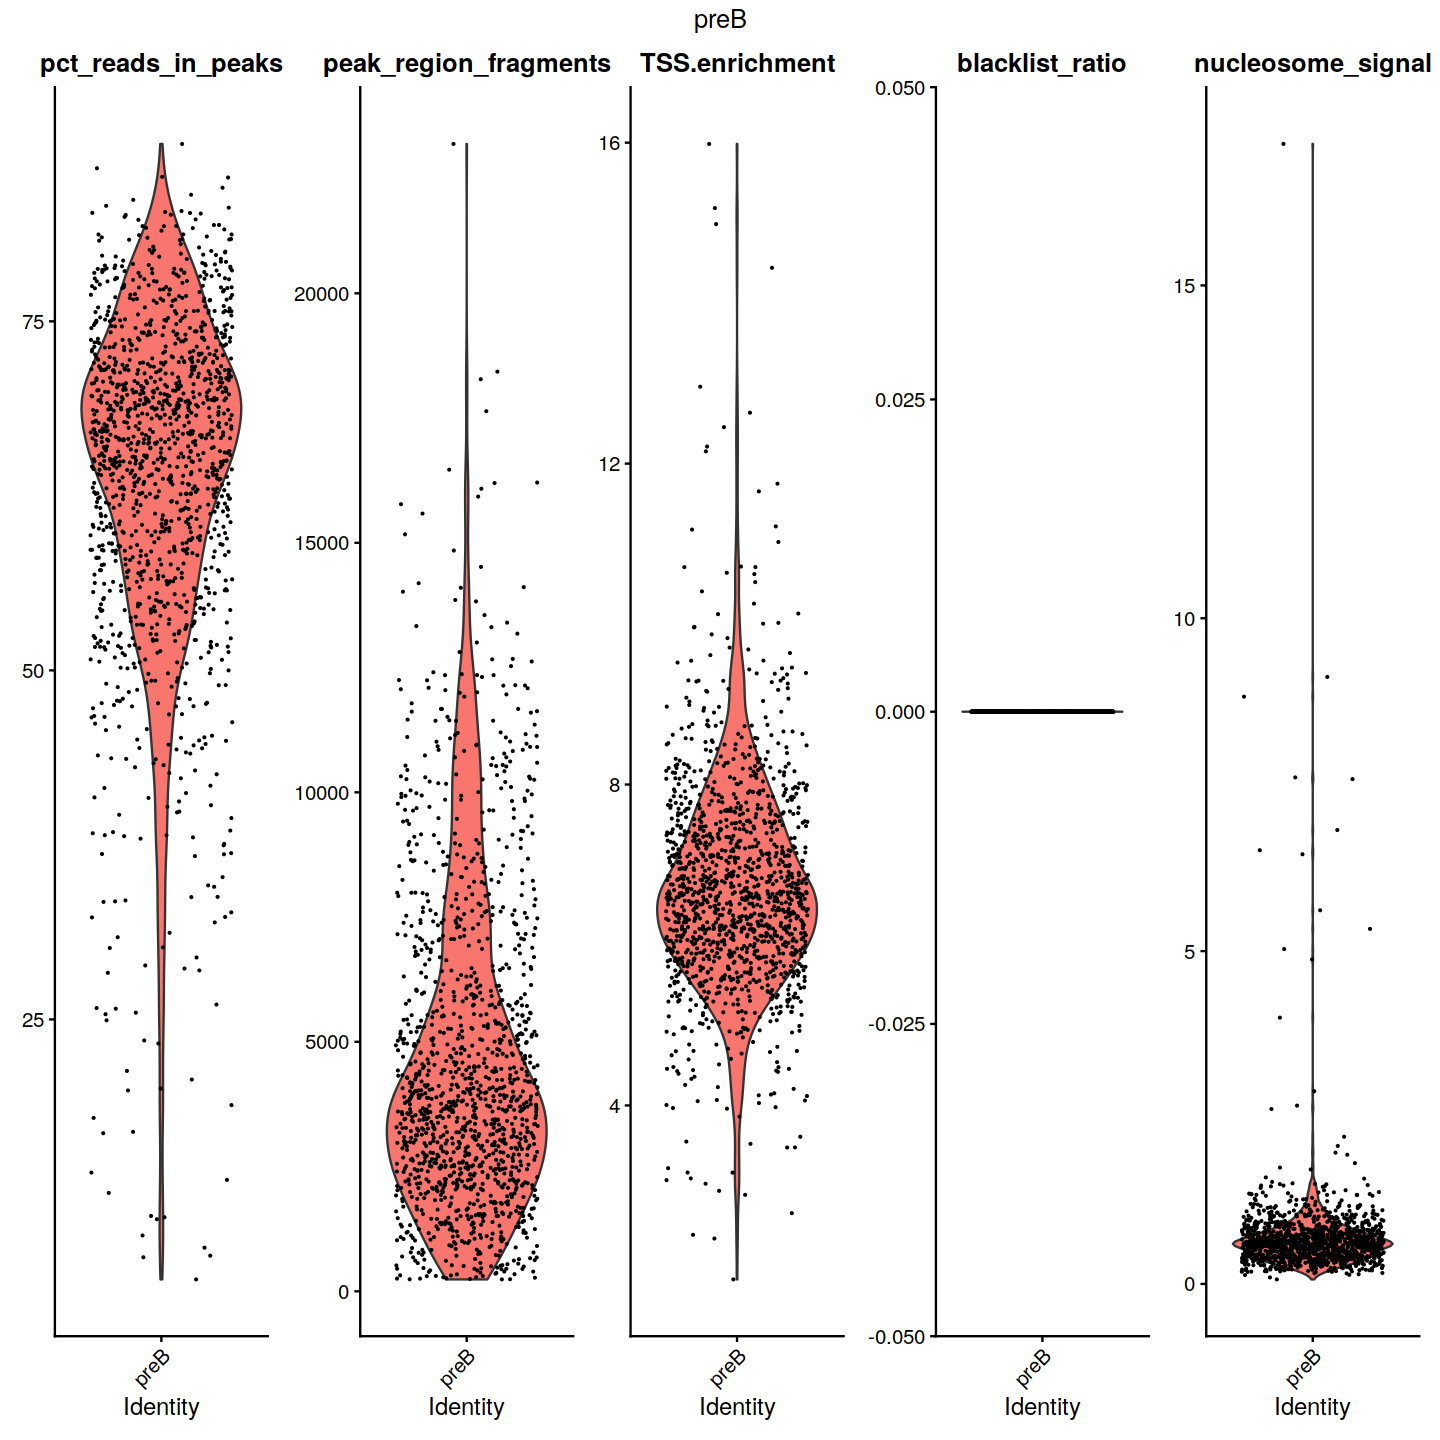

Saving 6.67 x 6.67 in image

Saving 6.67 x 6.67 in image



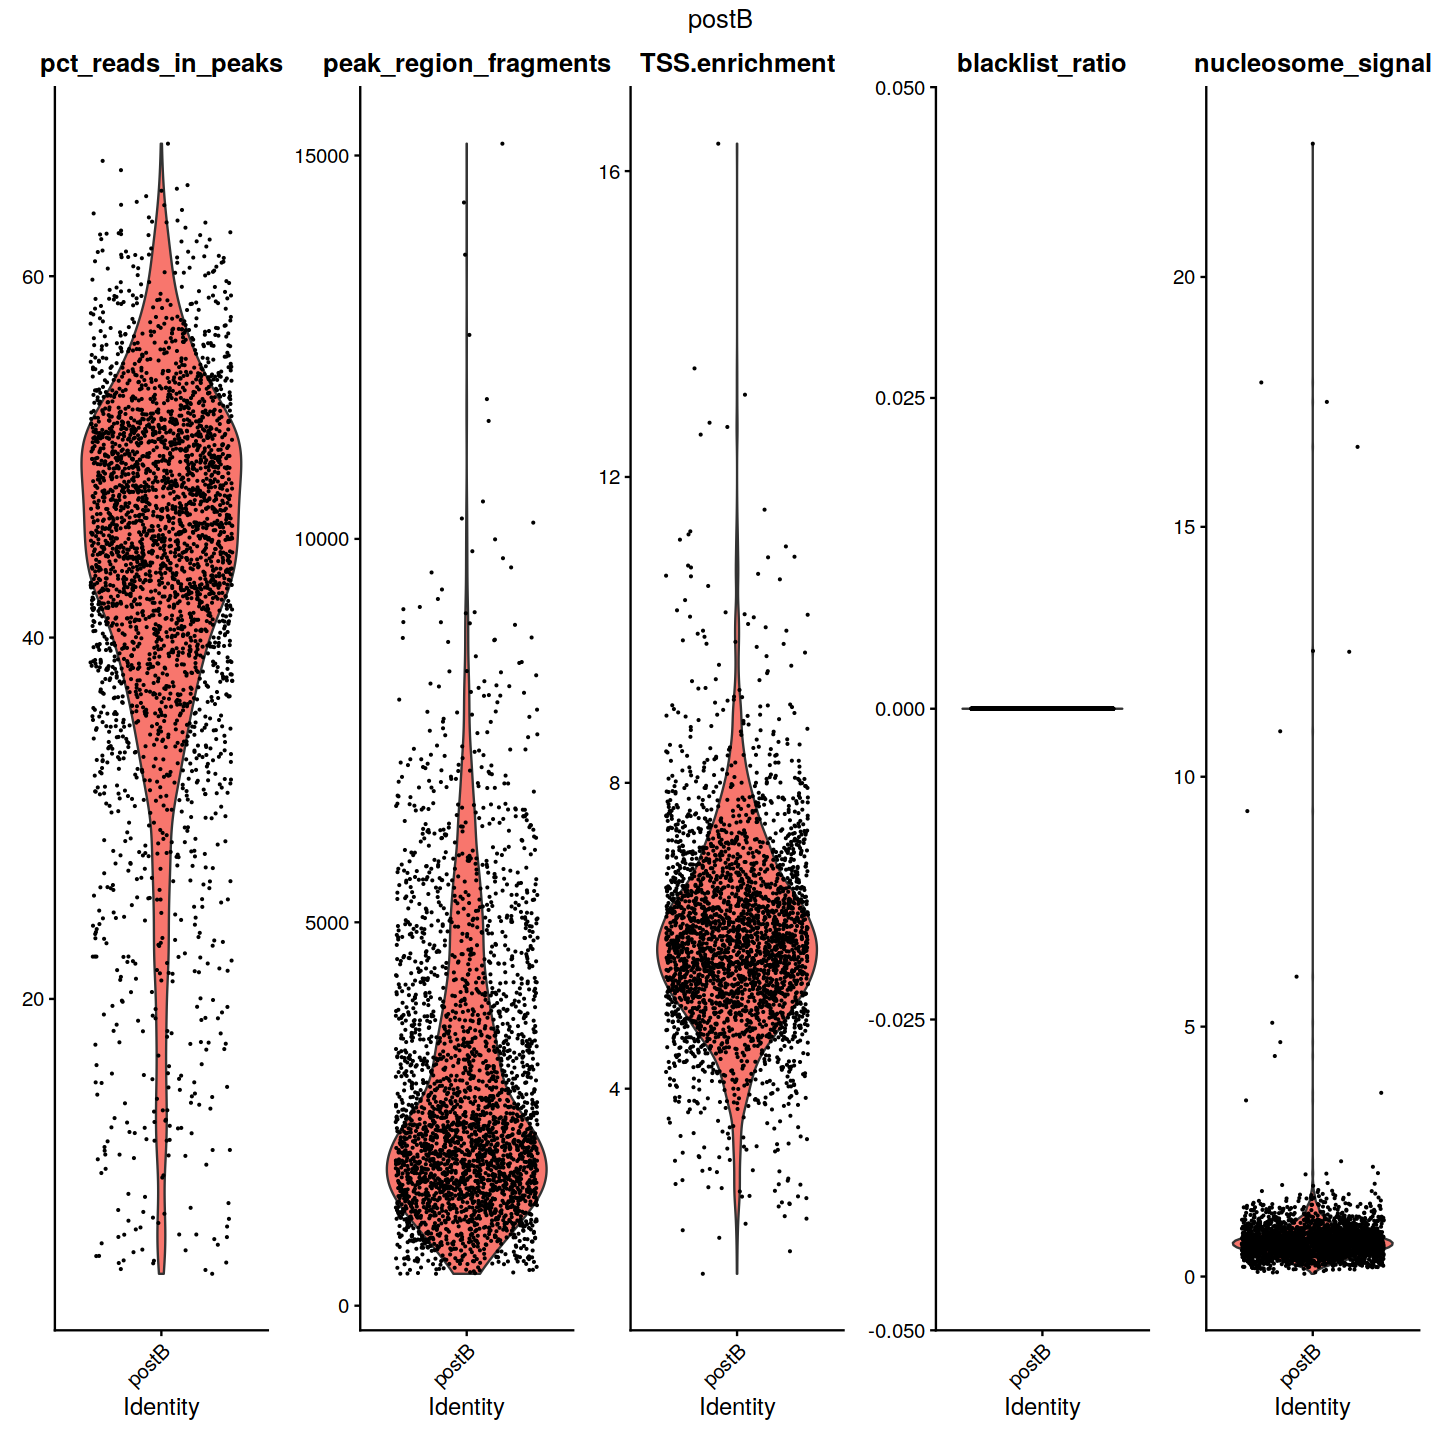

In [32]:
allSE <- lapply(allSE, qc)
saveRDS(allSE, file.path(outdir, paste0("allSamples.rds")))
lapply(allSE,vPlot)
ggsave(file.path(outdir, paste0("QC_01.png")))
ggsave(file.path(outdir, paste0("QC_01.pdf")))

In [ ]:
filtCells <- function(se, min_peak_region_fragments=10,
                      max_peak_region_fragments=15000,
                     min_pct_reads_in_peaks=15,
                     max_blacklist_ratio=0.05,
                     max_nucleosome_signal=4,
                     min_TSS_enrichment=2){
    print('se before filt')
    print(se)
    se <- subset(
      x = se,
      subset = peak_region_fragments > min_peak_region_fragments &
               peak_region_fragments < max_peak_region_fragments &
               pct_reads_in_peaks > min_pct_reads_in_peaks &
               blacklist_ratio < max_blacklist_ratio &
               nucleosome_signal < max_nucleosome_signal  &
               TSS.enrichment > min_TSS_enrichment
    )
    print('se after filt')
    print(se)
    return(se)
}

if (to.filt.cells){
    allSE <- lapply(allSE, filtCells,
                    min_peak_region_fragments=min_peak_region_fragments,
                    max_peak_region_fragments=max_peak_region_fragments,
                    min_pct_reads_in_peaks=min_pct_reads_in_peaks,
                    max_blacklist_ratio=max_blacklist_ratio,
                    max_nucleosome_signal=max_nucleosome_signal,
                    min_TSS_enrichment=min_TSS_enrichment)
}

# Merge

In [ ]:
# Add sample names to cell prefix here.
for (i in 1:length(allSE)){
    print(i)
    curr.SE <- allSE[[i]]
    allSE[[i]] <- RenameCells(allSE[[i]], add.cell.id=curr.SE$orig.ident[[1]])
}

allSE[[1]][["ATAC"]]

In [ ]:
# merge all datasets, adding a cell ID to make sure cell names are unique
# combined <- merge(
#   x = allSE[[1]],
#   y = unlist(allSE[2:length(allSE)]),
# )

if(length(sample_names) == 1){
    combined = allSE[[1]]
}else{
    combined <- merge(
      x = allSE[[1]],
      y = allSE[[2]])
}

if(length(sample_names) > 2) {
    for (i in 3:length(sample_names)){
        combined <- merge(x=combined,
                          y = allSE[[i]])
        }
}

In [ ]:
combined <- FindTopFeatures(combined, min.cutoff = 20)
combined

In [ ]:
combined$orig.ident <- factor(combined$orig.ident, levels = sample_names)

VlnPlot(
  object = combined,
  features = c('nCount_ATAC', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  split.by = "orig.ident",
  pt.size = 0.1,
  ncol = 3
)


In [ ]:
# Binarize and run LSI
combined <- BinarizeCounts(combined)
combined <- RunTFIDF(combined)
combined <- RunSVD(combined)
combined <- RunUMAP(combined, dims = lsi_start_comp:50, reduction = 'lsi')
DimPlot(combined, group.by = "proj", pt.size = 0.1)

In [ ]:
pDepthCorr <- DepthCor(combined)
pDepthCorr

### Split back into groups - add external sample_names

In [ ]:
sample_names <- c(ext_name, sample_names)

In [ ]:
allSE <- lapply(sample_names,  function(x) subset(combined, subset = orig.ident == x))
allSE

# Integrate, using external data as first entry, which serves as the anchor

In [ ]:
if( length(sample_names) == 1){
    integrated = allSE[[1]]
}else{
    # find integration anchors
    integration.anchors <- FindIntegrationAnchors(
      object.list = allSE, #c(ext,curr),
      anchor.features = allSE[[1]], #rownames(ext),
      reduction = "rlsi",
      dims = lsi_start_comp:30
    )

    # integrate LSI embeddings
    integrated <- IntegrateEmbeddings(
      anchorset = integration.anchors,
      reductions = combined[["lsi"]],
      new.reduction.name = "integrated_lsi",
      dims.to.integrate = 1:30
    )
}


In [ ]:
p1 <- DimPlot(combined, group.by = "proj")

# create a new UMAP using the integrated embeddings
integrated <- RunUMAP(integrated, reduction = "integrated_lsi", dims = 2:30)
p2 <- DimPlot(integrated, group.by = "proj")
ggsave(file.path(outdir,"integrated.batch.png"), dpi=300)
p2

In [ ]:
(p1 + ggtitle("Merged")) | (p2 + ggtitle("Integrated"))
ggsave(file.path(outdir,"integrated.merged.compare.png"), dpi=300)

In [ ]:
pDepthCorr <- DepthCor(integrated, reduction='integrated_lsi')
ggsave(file.path(outdir,"integrated.depthCor.png"), plot=pDepthCorr, dpi=300)

pDepthCorr

In [ ]:
#integrated <- RunUMAP(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindNeighbors(object = integrated, reduction = 'integrated_lsi', dims = 2:30)
integrated <- FindClusters(object = integrated, verbose = FALSE, algorithm = 3)

pclust <- DimPlot(object = integrated, label = TRUE) + NoLegend()
ggsave(file.path(outdir, "integrated.lsi.clusters.png"), pclust)
pclust

In [ ]:
# add the gene information to the object
DefaultAssay(integrated) <- "ATAC"
Annotation(integrated) <- annotations
gene.activities <- GeneActivity(integrated)


In [ ]:
mt_genes <- annotations[seqnames(annotations) == "chrM"]
dim(mt_genes)


In [ ]:
gene.activities <- gene.activities[!(rownames(gene.activities) %in% mt_genes$gene_name),]
# add the gene activity matrix to the Seurat object as a new assay and normalize it
integrated[['RNA']] <- CreateAssayObject(counts = gene.activities)
integrated <- NormalizeData(
  object = integrated,
  assay = 'RNA',
  normalization.method = 'LogNormalize',
  scale.factor = median(integrated$nCount_RNA)
)
DefaultAssay(integrated) <- 'RNA'

In [ ]:
saveRDS(integrated, file.path(outdir, paste0("allSamples.integrated.rds")))

In [ ]:
Idents(integrated) <- "orig.ident"
VlnPlot(
  object = integrated,
  features = c('nCount_ATAC', 'peak_region_fragments', 'passed_filters',
               'duplicate', 'unmapped'),
  split.by = "orig.ident",
  pt.size = 0.1,
  ncol = 3
)

ggsave(file.path(outdir, paste0("QC_02.png")))

In [33]:
sessionInfo()

R version 4.1.1 (2021-08-10)
Platform: x86_64-conda-linux-gnu (64-bit)
Running under: Ubuntu 20.04.3 LTS

Matrix products: default
BLAS/LAPACK: /home/isaac/miniconda3/envs/mttrace/lib/libopenblasp-r0.3.18.so

locale:
 [1] LC_CTYPE=en_US.UTF-8       LC_NUMERIC=C              
 [3] LC_TIME=en_US.UTF-8        LC_COLLATE=en_US.UTF-8    
 [5] LC_MONETARY=en_US.UTF-8    LC_MESSAGES=en_US.UTF-8   
 [7] LC_PAPER=en_US.UTF-8       LC_NAME=C                 
 [9] LC_ADDRESS=C               LC_TELEPHONE=C            
[11] LC_MEASUREMENT=en_US.UTF-8 LC_IDENTIFICATION=C       

attached base packages:
[1] stats4    stats     graphics  grDevices utils     datasets  methods  
[8] base     

other attached packages:
 [1] Rsamtools_2.10.0     Biostrings_2.62.0    XVector_0.34.0      
 [4] future_1.23.0        dplyr_1.0.7          metap_1.1           
 [7] cowplot_1.1.1        magrittr_2.0.1       data.table_1.14.2   
[10] patchwork_1.1.1      ggplot2_3.3.5        Signac_1.4.0        
[13] SeuratObject_